In [1]:
"""
Cet technique marche beaucoup mieux que dans tensorflow, avec en très peu de temps. 
Ce modèle fonctionne mieux que l'autre dans tensorflow parce qu'une raison évidente: 
il utilise méthode teacher forcing Un autre problème avec ce méthode, 
c'est dropout qui donne une technique plus ou moins bon. Il donne la 
réponse plus tôt aléatoire pour une question. En cas général, 
ce la peut être intéressant, mais dans notre cas, il est très important 
qu'il capture le mot clés 
(donc, surtout on risque de supprimer le mot clés, qui rendra une mauvais réponse)
modèle est bien entrainé, donc, il ne sert à rien d'entrainer encore.
hidden_size =45 tres mauvais; =70 bien; =100 tres bien; =120 très bien; =150 overfit.
hidden_size 50 20%
hidden_size 70 33%
hidden_size 120 28%
"""
#from IPython.display import display, Markdown
#display(Markdown("### Pour lancer un chat, il suffit de taper en même temps CTRL et ENTER"))
#display(Markdown("### Pour arrêter le mode chat, il suffit de taper ENTER dans votre conversation"))
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import data
import config

use_cuda = torch.cuda.is_available()

hidden_size = 90
SOS_token  = config.SOS_token
EOS_token  = config.EOS_token
MAX_LENGTH = config.MAX_LENGTH
stopwords  = config.STOPWORDS
learning_rate = config.LEARNING_RATE
teacher_forcing_ratio = 0.2
dropout = config.DROPOUT

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    """
    Whith a tring s, we make it in lower case, delete \n if exists at 
    the end of string, and delete specical case ? . and !
    """
    s = s.lower().strip()
    s = re.sub(r"([,.!?\n])", r"", s)# sumprimer tous les caractères .! et ?
    #s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

def readLangs():
    print("Reading lines...")
    pairs_trains, pairs_tests = [], []   
    encode_train = open(os.path.join(config.PROCESSED_PATH, "question_train.txt"), 'r')
    decode_train = open(os.path.join(config.PROCESSED_PATH, "answer_train.txt"), 'r')
    encode, decode = encode_train.readline(), decode_train.readline()
    while encode and decode:
        encode, decode = normalizeString(encode), normalizeString(decode)
        decode = 'SOS '+ decode + ' EOS'
        pairs_trains.append([encode, decode])
        encode, decode = encode_train.readline(), decode_train.readline()
    encode_train.close()
    decode_train.close()
    encode_test = open(os.path.join(config.PROCESSED_PATH, "question_test.txt"), 'r')
    decode_test = open(os.path.join(config.PROCESSED_PATH, "answer_test.txt"), 'r')
    encode, decode = encode_test.readline(), decode_test.readline()
    while encode and decode:
        encode, decode = normalizeString(encode), normalizeString(decode)
        decode = 'SOS '+ decode + ' EOS'
        pairs_tests.append([encode, decode])
        encode, decode = encode_test.readline(), decode_test.readline()
    encode_test.close()
    decode_test.close()
    return pairs_trains, pairs_tests


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData():
    input_lang = Lang('question')
    output_lang = Lang('answer')
    pairs_trains, pairs_tests = readLangs()
    print("Read %s sentence pairs of training set" % len(pairs_trains))
    print("Read %s sentence pairs of test set" % len(pairs_tests))
    pairs_trains = filterPairs(pairs_trains)
    pairs_tests = filterPairs(pairs_tests)
    for i  in range(len(pairs_trains)) :
        pair = pairs_trains[i]
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    for i  in range(len(pairs_tests)) :
        pair = pairs_tests[i]
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs_trains,pairs_tests

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
def closetWord(word, lang):
    """
    find and return the closest word in lang
    """
    Dict = lang.word2index
    corpus = lang.index2word
    if word in Dict:
        return word
    else:
        distance = levenshtein(word, corpus[0])
        close_word = corpus[0]
        for ix in corpus:
            if levenshtein(word, corpus[ix]) <distance:
                close_word = corpus[ix]
                distance = levenshtein(word, corpus[ix])
        if distance <=1:
            return close_word
        else:
            return word
        
def normalizeSentenceInChat(sentence):
    sentence = sentence.strip().lower().split()
    s = [closetWord(word, input_lang) for word in sentence]
    return ' '.join(s)
        
        
            

def indexesFromSentence(lang, sentence):
    #sentence = normalizeSentence
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index ]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)


def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
def get_skip_step(n_iters):
    return int(n_iters/10)

def trainIters(n_iters, plot_every=100, learning_rate=learning_rate):
    encoder, decoder = restore_model()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    skip_step = get_skip_step(n_iters)
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs_trains))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % skip_step == 0:
            print_loss_avg = print_loss_total / skip_step
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    save_model(encoder, decoder)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    #sentence = normalizeSentenceInChat(sentence)
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        ni = int(ni)
        if ni == EOS_token:
            #decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words


def evaluate_randomly(n_iters=200, test=True):
    encoder, decoder = restore_model()
    if not test:
        print('TEST error of word to word on TRAIN')
        list_print_random = random.sample(range(n_iters),20 )
        total_loss = 0
        for i in range(n_iters):
            pair = random.choice(pairs_trains)
            output_words = evaluate(encoder, decoder, pair[0])
            if 'EOS' in output_words:
                l = output_words.index('EOS')+1
            else:
                l = len(output_words)+1
            reponse = ' '.join(output_words[:l])
            loss = _evaluate_by_right_word(pair[1], reponse)
            total_loss +=loss
            if i in list_print_random:
                print('Question: ', pair[0])
                print('Réponse: ', pair[1])
                print('Bot: {}   ACCURACY {:.1f}'.format(reponse, 1-loss))
                print('-'*50)
        print('Accuracy of good answer word to word: ', 1-total_loss/n_iters)
    else:
        n_iters = len(pairs_tests)
        total_loss = 0
        random_print_index = random.sample(range(n_iters), 20)
        for i in range(n_iters):
            pair = pairs_tests[i]
            output_words= evaluate(encoder, decoder, pair[0])
            if 'EOS' in output_words:
                l = output_words.index('EOS')+1
            else:
                l = len(output_words)+1
            reponse = ' '.join(output_words[:l])
            loss = _evaluate_by_right_word(pair[1], reponse)
            if i in random_print_index:
                print('Question: ', pair[0])
                print('Réponse: ', pair[1])
                print('Bot: {}. ACCURACY {:.1f}'.format(reponse, 1-loss))
                print('-'*50)
            total_loss +=loss
        print('Test on {}'.format(n_iters))
        print('Accuracy by percent of true words {}'.format(1-total_loss/n_iters))
       
   
    
def _evaluate_by_right_word(reponse, bonne_reponse):
    reponse = reponse.split()
    bonne_reponse = bonne_reponse.split()
    min_length = min(len(reponse), len(bonne_reponse))
    max_length = max(len(reponse), len(bonne_reponse))
    error = max_length-min_length
    for i in range(min_length):
        if reponse[i] != bonne_reponse[i]:
            error +=1
    return error/max_length      
        
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
def save_model(encoder, decoder):        
    make_dir(config.CHECK_POINT_PATH)
    path1= os.path.join(config.CHECK_POINT_PATH, 'encoder_no_att_90__1.ck')
    path2 = os.path.join(config.CHECK_POINT_PATH, 'decoder_no_att_90__1.ck')
    try: 
        os.remove(path1)  
        os.remove(path2)
    except FileNotFoundError:
        pass
    torch.save(encoder,path1)
    torch.save(decoder, path2)
    
memo = {}
def levenshtein(s, t):
    """
    Pour calculer la distance  Levenshtein entre 2 string s et t
    """
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    cost = 0 if s[-1] == t[-1] else 1
       
    i1 = (s[:-1], t)
    if not i1 in memo:
        memo[i1] = levenshtein(*i1)
    i2 = (s, t[:-1])
    if not i2 in memo:
        memo[i2] = levenshtein(*i2)
    i3 = (s[:-1], t[:-1])
    if not i3 in memo:
        memo[i3] = levenshtein(*i3)
    res = min([memo[i1]+1, memo[i2]+1, memo[i3]+cost])
    
    return res
    
def restore_model():
    #hidden_size = hidden_size
    path1 = os.path.join(config.CHECK_POINT_PATH, 'encoder_no_att_90__1.ck')
    path2 = os.path.join(config.CHECK_POINT_PATH, 'decoder_no_att_90__1.ck')
    if os.path.exists(path1)and os.path.exists(path2):
        print('Reading the parameters from {} and {}...'.format(path1, path2))
        encoder = torch.load(path1)
        decoder = torch.load(path2)
    else:
        print('Initializing fresh parameters...')
        encoder = EncoderRNN(input_lang.n_words, hidden_size)
        decoder = DecoderRNN(hidden_size, output_lang.n_words,2)

    if use_cuda:
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    return encoder, decoder  

def construct_dict(lang):
    in_file = open(os.path.join(config.PROCESSED_PATH, 'dictionnary.txt'), 'r')
    lines = []
    dicts = lang.word2index.copy()
    for line in in_file:
        line = line.strip().split('|')
        for word in dicts:
            if str(word) in line and len(word)>0:
                line.insert(0,str(word))
                lines.append(line)
                del dicts[str(word)]
                break
    return lines

def find_close_line(lines, lang, line):
    LINE = []
    for word in line.strip().split():
        if word in lang.word2index:
            LINE.append(word)
        else:
            for pharse in lines:
                if word in pharse:
                    LINE.append(pharse[0])
                    break
    return ' '.join(LINE)

def chat():
    encoder, decoder = restore_model()
    make_dir(config.CHECK_POINT_PATH)
    lines = construct_dict(input_lang)
    output_file = open(os.path.join(config.CHECK_POINT_PATH, 'convos70.txt'), 'a+')
    print('Bonjour, c\'est le Bot d\'AVICEN, Je peux vous aider? \n')
    while True:
            line = str(input('Vous: '))
            if len(line) > 0 and line[-1] == '\n':
                line = line[:-1]
            if line == '':
                break
            line = normalizeString(line)
            transform_line  = normalizeSentenceInChat(line)
            transform_line = find_close_line(lines, input_lang, transform_line)
            print('LIGNE TRANFORMÉ: ', line)
            output_file.write('VOUS ++++ ' + line + '\n')
            reponse, _ = evaluate(encoder, decoder, transform_line)
            reponse = " ".join(reponse[:-1])
            output_file.write('BOT ++++ ' + reponse + '\n')
            print('Bot AVICEN: ', reponse)
            print('-'*50)
    output_file.close()
    
def langTest():
    pairs_test = []   
    test_file = open(os.path.join(config.PROCESSED_PATH, "test.txt"), 'r')
    i=0
    for line in test_file:
        line = normalizeString(line)
        if i%2 ==0:
            question = line
        else:
            answer = line
            pairs_test.append([question, answer])
        i +=1
    return pairs_test  

def test(pairs_test):
    """
    Use test for know how our model is good
    """
    encoder, decoder = restore_model()
    total_loss = 0
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    for pair in pairs_test:
        variable = variablesFromPair(pair)
        loss = train( variable[0], variable[1], encoder, decoder, encoder_optimizer, decoder_optimizer,\
                     criterion= criterion)
        total_loss +=loss
    Length_inputs = len(pairs_test) if len(pairs_test) !=0 else 1
    return total_loss/Length_inputs

def construct_train_test_set(pairs):
    max_length = len(pairs)
    portion_of_train = int(max_length*0.85)
    index_of_train = random.sample(range(max_length), portion_of_train)
    train, test = [], []
    for index in range(max_length):
        if index in index_of_train:
            train.append(pairs[index])
        else:
            test.append(pairs[index])
    return train, test

if __name__=='__main__':
    try:
        input_lang
    except NameError : 
        input_lang, output_lang, pairs_trains, pairs_tests = prepareData()


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Reading lines...
Read 563 sentence pairs of training set
Read 141 sentence pairs of test set
Counted words:
question 643
answer 762


Reading the parameters from check_point/encoder_no_att_90__1.ck and check_point/decoder_no_att_90__1.ck...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:288: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1m 40s (- 15m 4s) (10000 10%) 0.0777
3m 18s (- 13m 12s) (20000 20%) 0.0675
4m 57s (- 11m 33s) (30000 30%) 0.0621
6m 35s (- 9m 53s) (40000 40%) 0.0596
8m 15s (- 8m 15s) (50000 50%) 0.0586
9m 54s (- 6m 36s) (60000 60%) 0.0534
11m 34s (- 4m 57s) (70000 70%) 0.0501
13m 12s (- 3m 18s) (80000 80%) 0.0538
14m 52s (- 1m 39s) (90000 90%) 0.0514
16m 32s (- 0m 0s) (100000 100%) 0.0545


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 432x288 with 0 Axes>

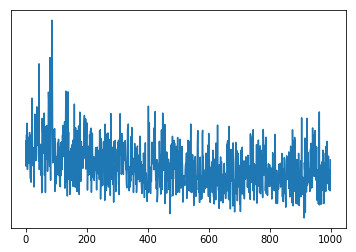

In [10]:
trainIters(100000, learning_rate = 0.005)

In [3]:
list_mot_cles =[]
for pair in pairs_trains:
    for word in pair[1].split():
        if '#' in word and word not in list_mot_cles:
            list_mot_cles.append(word)

In [5]:
for word in list_mot_cles:
    print(word, end = '      ')

#oui/non#      #nb_véhicules#      #date#      #adresse#      #tel_comptabilite#      #vin#      #kpi_pollution#      #kpi_maintenance#      #kpi_gestion#      #co2#      #kpi#      #roi#      #code_dtc#      #priorité#      #transmission#vin#      #énergie#      #cv#      #consumption#      #date_fin_contrat#      #date_last_entretien#      #mode_financement_vin#      #trajet#      #état_traffic#      #geoloc#      #base_marque#      #date_debut_contrat#      #km#      #nb_module#      #lab_program#      #val_trust_low#      #val_trust_high#      #listing_vin#      #vin_proxi#      #nb_place#      #lastname#      #user#      #list_module#      #detail_module#      #tx_dispo#      #calcul_roadtrip#      #map_meteo#      #spec_tyre#      #tpms#      #total_veh_movement#      #list_vin_free#      #nb_vehicule#      #tel_sav#      #list_vin_immediat#      #list_vin_morning#      #list_vin_afternoon#      #list_vin_tonight#      #list_alert#      #list_podium#      #nb_instances#      #lis

In [7]:
for pair in pairs_trains:
    if "#priorité#" in pair[1]:
        print(pair)

['quelles sont les urgences à traiter', 'SOS les urgences à traiter sont #priorité# EOS']
['quelles sont les urgences', 'SOS vos urgences sont #priorité# EOS']
